# **Predicting Concrete Compressive Strength**

## 1. Introduction

Concrete is a fundamental material in civil engineering. Its compressive strength is crucial for ensuring the safety and durability of structures. However, accurately determining this strength is challenging because it depends on a non-linear relationship between several factors, including the concrete's age and the proportions of its components, such as cement, blast furnace slag, fly ash, water, superplasticizer, coarse aggregate and fine aggregate.

The aim of this project is to apply machine learning techniques to improve the prediction of concrete strength in order to contribute to better design, quality control and optimization of resources in construction.

## 2. Data Analytics

To enable a meaningful analysis, this chapter begins with a brief description of the dataset, including its origin, structure, and variable definitions. In preparation for modeling, several preprocessing steps are performed. These include importing the raw data, correcting data types, handling missing values, and defining input and the target variable. This ensures that the data is clean, consistent, and ready for subsequent machine learning analysis.

### 2.1. Data set

The dataset originates from the UCI Machine Learning Repository and comprises 1,030 observations, 8 quantitative input variables and 1 quantitative output variable.

The input variables are `cement`, `blast furnace slag`, `fly ash`, `water`, `superplasticizer`, `coarse aggregate`, `fine aggregate` and `age`. Except for `age`, the other variables represent ingredient quantities in the concrete mixture, measured in *kg in a $m^{3}$* mixture. `Age` is measured in *days*. `Concrete compressive strength`, the target variable, is measured in *MPa*.

### 2.2. Data import

The first step of the analysis involves importing the required libraries and loading the dataset.

In this case, the dataset is read from `Concrete_data.csv`. This file contains the composition of different concrete mixtures along with their corresponding compressive strength values. To ensure consistent formatting, parameters such as the field separator, decimal notation, and encoding are explicitly specified during data import. Additionally, column names are stripped of leading and trailing whitespaces for cleaner access.

The table below displays the first few rows of the dataset. Each row represents a unique concrete mixture.

In [1]:
import statsmodels.api as sm
import numpy as np
import pandas as pd
import seaborn as sns
import scipy
import sklearn
import graphviz
import os
import re

from matplotlib import pyplot as plt
from pandas.plotting import scatter_matrix
from itertools import combinations
from IPython.display import display, Math, Image

from statsmodels.stats.outliers_influence import OLSInfluence
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV, cross_validate, RandomizedSearchCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, FunctionTransformer
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import mean_squared_error, make_scorer, r2_score, mean_absolute_error,root_mean_squared_error
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.inspection import PartialDependenceDisplay,partial_dependence


%matplotlib inline
plt.style.use('ggplot') 
sns.set_style("darkgrid")
# print numpy arrays with precision 4
np.set_printoptions(precision=4)

In [2]:
concrete_df = pd.read_csv('./Concrete_data.csv', 
                          sep = ',',
                         decimal = ',',
                         encoding = 'UTF-8')
concrete_df.columns = concrete_df.columns.str.strip()
concrete_df.head()

Cement (component 1)(kg in a m^3 mixture)  \
0                                    540.0    
1                                    540.0    
2                                    332.5    
3                                    332.5    
4                                    198.6    

  Blast Furnace Slag (component 2)(kg in a m^3 mixture)  \
0                                               0.0       
1                                               0.0       
2                                             142.5       
3                                             142.5       
4                                             132.4       

  Fly Ash (component 3)(kg in a m^3 mixture)  \
0                                       0.0    
1                                       0.0    
2                                       0.0    
3                                       0.0    
4                                       0.0    

  Water  (component 4)(kg in a m^3 mixture)  \
0                                    162.0    
1                                    162.0    
2                                    228.0    
3                                    228.0    
4                                    192.0    

  Superplasticizer (component 5)(kg in a m^3 mixture)  \
0                                               2.5     
1                                               2.5     
2                                               0.0     
3                                               0.0     
4                                               0.0     

  Coarse Aggregate  (component 6)(kg in a m^3 mixture)  \
0                                            1040.0      
1                                            1055.0      
2                                             932.0      
3                                             932.0      
4                                             978.4      

  Fine Aggregate (component 7)(kg in a m^3 mixture)  Age (day)  \
0                                            676.0          28   
1                                            676.0          28   
2                                            594.0         270   
3                                            594.0         365   
4                                            825.5         360   

  Concrete compressive strength(MPa, megapascals)  
0                                          79.99   
1                                          61.89   
2                                          40.27   
3                                          41.05   
4                                          44.30

### 2.3. Data type correction and missing value handling

To ensure numerical consistency across all variables, features initially read as object types — due to locale-specific formatting or encoding — are explicitly converted to numeric data types using `pd.to_numeric`. Invalid entries that cannot be parsed are coerced into NaN values. Subsequently, a missing value check is conducted, and all rows containing NaN entries are removed from the dataset to maintain data integrity and compatibility with machine learning algorithms.

The table below shows the original and converted data types of all variables. Object-type features were converted to numeric formats (e.g., float64) to enable their use in regression analysis. Finally, the number of rows containing missing values (NaN) is also reported.

In [3]:
print("Original data types：")
print(concrete_df.dtypes)

# object to numeric
for col in concrete_df.columns:
    if concrete_df[col].dtype == 'object':
        concrete_df[col] = pd.to_numeric(concrete_df[col], errors='coerce')


print("\nTransfromed datatypes：")
print(concrete_df.dtypes)

# NaN 
print("\nRows with NaN：", concrete_df.isna().sum().sum())

# Drop NaN
concrete_df = concrete_df.dropna()

Original data types：
Cement (component 1)(kg in a m^3 mixture)                object
Blast Furnace Slag (component 2)(kg in a m^3 mixture)    object
Fly Ash (component 3)(kg in a m^3 mixture)               object
Water  (component 4)(kg in a m^3 mixture)                object
Superplasticizer (component 5)(kg in a m^3 mixture)      object
Coarse Aggregate  (component 6)(kg in a m^3 mixture)     object
Fine Aggregate (component 7)(kg in a m^3 mixture)        object
Age (day)                                                 int64
Concrete compressive strength(MPa, megapascals)          object
dtype: object

Transfromed datatypes：
Cement (component 1)(kg in a m^3 mixture)                float64
Blast Furnace Slag (component 2)(kg in a m^3 mixture)    float64
Fly Ash (component 3)(kg in a m^3 mixture)               float64
Water  (component 4)(kg in a m^3 mixture)                float64
Superplasticizer (component 5)(kg in a m^3 mixture)      float64
Coarse Aggregate  (component 6)(kg in a 

#### Renaming columns/features:
In the following chapters the feature names will be shortened (omitting their component number and units) so that the visualizations/diagrams are more compact and the readability of tables is improved. The component numbers in tables will be shown in separate columns so the preserved order can be checked.

In [4]:
def clean_column_name(col):
    # Remove parentheses and their contents (component numbers and units) from column names
    col = re.sub(r'\(.*?\)', '', col)
    col = re.sub(r'component\s*\d*', '', col, flags=re.IGNORECASE)
    return col.strip().replace('  ', ' ')

concrete_df.columns = [clean_column_name(col) for col in concrete_df.columns]
concrete_df.head()

# Relabel the response variable
label_column = 'Concrete compressive strength'
# Redefine feature columns after cleaning
feature_columns = [c for c in concrete_df.columns if c != label_column]
#define all the variables we need for the linear regression with concrete compressive strength as response and all other variables as possible features
X = concrete_df[feature_columns].values
y = concrete_df[label_column].values
p = len(feature_columns)
print("Features are:", feature_columns,
      "\nThe response variable is:", label_column)


Features are: ['Cement', 'Blast Furnace Slag', 'Fly Ash', 'Water', 'Superplasticizer', 'Coarse Aggregate', 'Fine Aggregate', 'Age'] 
The response variable is: Concrete compressive strength


#### Explanation of relevant variables:

The following table shows the meaning and expected effect of respective variables on strength. 
| Variable             | Meaning                              | Expected Effect on Strength    |
| -------------------- | ------------------------------------ | ------------------------------ |
| `cement`             | Binder                               | increases strength          |
| `blast_furnace_slag` | Supplementary binder                 | increases strength or neutral                  |
| `fly_ash`            | Supplementary binder                 | increase strength or neutral                  |
| `water`              | Affects workability and hydration    | decreases strength (excess) |
| `superplasticizer`   | Increases workability, reduces water | increase or decrease depending on context  |
| `coarse_aggregate`   | Filler                               | neutral or mild effect         |
| `fine_aggregate`     | Filler                               | neutral or mild effect         |
| `age`                | Curing time                          | increases strength          |


#### Feature scaling

In [5]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled

array([[ 2.4779, -0.8569, -0.8471, ...,  0.8632, -1.2177, -0.2797],
       [ 2.4779, -0.8569, -0.8471, ...,  1.0562, -1.2177, -0.2797],
       [ 0.4914,  0.7955, -0.8471, ..., -0.5265, -2.2409,  3.5531],
       ...,
       [-1.2701,  0.7596,  0.8506, ..., -1.0361,  0.0801, -0.2797],
       [-1.1686,  1.3081, -0.8471, ...,  0.2146,  0.1912, -0.2797],
       [-0.194 ,  0.3085,  0.3769, ..., -1.3951, -0.1507, -0.2797]],
      shape=(1030, 8))

#### Distribution of target variable

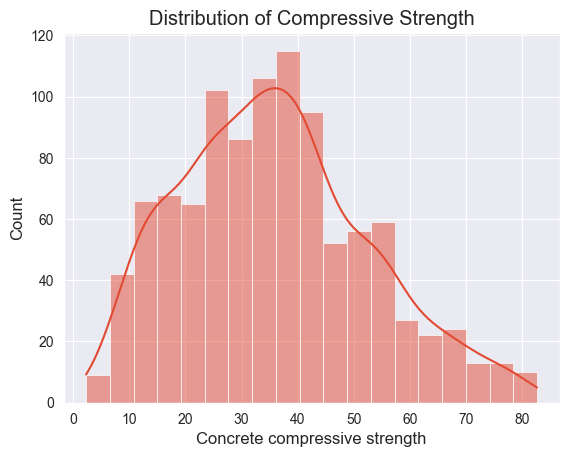

In [6]:
sns.histplot(concrete_df[label_column], kde=True)
plt.title("Distribution of Compressive Strength")
plt.show()

The sns.histplot clearly illustrates that the compressive strength data is not uniformly or normally distributed. Instead, it shows a sporadic and spread-out distribution with many unique or rarely occurring strength values, and potentially some concentrations at the extreme ends of the
measured range.
The data distribution is sparsity, lack of strong central Tendency, so we need to avoid assumption-heavy models (Simple linear regression) and consider robust models (Decision-tree is expected performing the best).
It doesn’t means that we don’t try simple linear regression, but maybe it can tell why linear regression doesn’t perform well

#### Correlation between relevant variables:

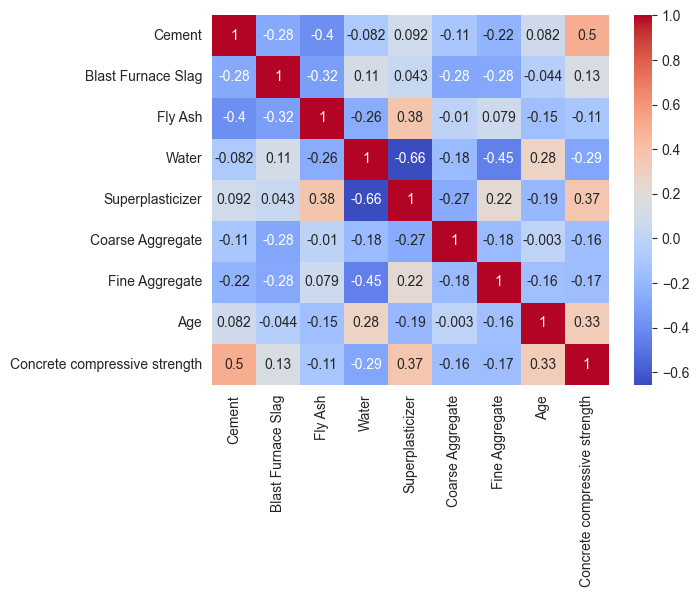

In [7]:
corr = concrete_df.corr(numeric_only=True)
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.show()

#### Variables that influence concrete strength:

According to the result of the heatmap, it can be seen that **cement** has a moderately strong positive correlation with concrete strength with a value of +0.50, which indicates more cement usually leads to stronger concrete. **Superplasticizer** also has a positive effect with a value of +0.37.
**Age** has a positive effect too , because concrete gets stronger over time.
**Water** has a negative correlation with strength of -0.29, which means more water tends to weaken concrete. This observation is consistent with **Abrams' water-to-cement ratio pronouncement**, which emphasizes that increased water relative to cement typically reduces concrete strength.

#### Multicollinearity:

The highest multicollinearity is the correlation between **water and superplasticizer**, which has a value of -0.66. This indicates they carry overlapping and opposite information. There is also moderate correlation among **cement**, **blast furnace slag**, and **fly ash** because these may act as partial substitutes in the concrete mix, so they tend to move in opposite directions. 

In [8]:
VIFs = [(predictor, variance_inflation_factor(X,_)) \
        for _,predictor in enumerate(list(feature_columns))] 
print('Variance Inflation Factors')
for tup in VIFs:
    print('{:20}'.format(tup[0]), '{:.3f}'.format(tup[1]))

Variance Inflation Factors
Cement               15.457
Blast Furnace Slag   3.329
Fly Ash              4.148
Water                82.158
Superplasticizer     5.471
Coarse Aggregate     84.956
Fine Aggregate       72.791
Age                  1.699


The variance inflation factors are larger for cement, blast furnace slag, fly ash, water, coarse aggregate, fine aggregate. This also indicates multi-collinearity of the factors mention above.

As mentioned in the lecture content of Machine Learning and Data Analytics(MLDA), VIF equal to 1 shows the absence of collinearity Usually, there is collinearity when VIF is larger than 5.

### Machine Learning Methods:
This project aims to predict concrete compressive strength which is a problem with a quantitative response. According to the lecture content in the fundamental part of MLDA, this task is a **regression task**. In the following part, linear regression, ridge regression, lasso regression, one decision-tree based method are applied. 

### Cross validation:

Validation set approach:

Training and test set split:

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=0, shuffle=True)

#### K-fold cross validation:

For supervised machine learning, the goal is to develop a model that can perform accurately not only on the data it was trained on, but also on previously unseen data. To evaluate a model's generalization ability, the **K-fold** method is utilized as the cross validation method.

In [10]:
# define the kfold, shuffle the training and test dataset every time
kf = KFold(n_splits=10, random_state = 0, shuffle = True)

##### Scorers for the model

In [11]:
# Create MSE scorer 
mse_scorer = make_scorer(mean_squared_error)

# Create r2 scorer 
r2 = make_scorer(r2_score)

### Explanation of the dataset with statsmodel:

##### Statsmodel, outliers and high leverege points:

In [12]:
#Statsmodel fitting, it is used to show the p-values
X_stat = sm.add_constant(concrete_df.iloc[:,0:-1])
y_stat = concrete_df[label_column]

statmodel = sm.OLS(y_stat,X_stat)
estimate = statmodel.fit()

print(estimate.summary())

                                  OLS Regression Results                                 
Dep. Variable:     Concrete compressive strength   R-squared:                       0.616
Model:                                       OLS   Adj. R-squared:                  0.613
Method:                            Least Squares   F-statistic:                     204.3
Date:                           Mon, 07 Jul 2025   Prob (F-statistic):          6.29e-206
Time:                                   17:24:33   Log-Likelihood:                -3869.0
No. Observations:                           1030   AIC:                             7756.
Df Residuals:                               1021   BIC:                             7800.
Df Model:                                      8                                         
Covariance Type:                       nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
-------------

According to the result of the fitted model, there is a relationship between the response of concrete compressive strength and **cement, blast furnace slag, fly ash, water, superplasticizer and age**, because they have low p-values, which is smaller than 0.05.

Interpretation:

**R-squared:** About 62% of the variance in compressive strength is explained by the model. Decent, but not very high.

**Adj. R-squared:** Adjusted for number of predictors, confirms the model is moderately good.

**F-statistic:** High F -> model is statistically significant overall.

**Prob (F-statstoc):** confirms that the predictors are jointly significant.

Problem:

**Omnibus:** Minor deviation from normality in residuals.

**Durbin-Watson:** is smaller than 2, suggests positive autocorrelation in residuals, which is not ideal, but not catastrophic here.

To improve the model, we will try next step regularized models (e.g. Ridge or Lasso) to deal with correlated predictors, and we will scale the features and use **scikit-learn** for better predictions.

In [13]:
# Obtain the residuals, studentized residuals and the leverages
fitted_values = estimate.fittedvalues
residuals = estimate.resid.values
studentized_residuals = OLSInfluence(estimate).resid_studentized_internal
leverages = OLSInfluence(estimate).influence

Outliers are: [np.int64(381), np.int64(383)]
Comments on joint outliers (in both ax2 and ax3): [np.int64(381), np.int64(383)]


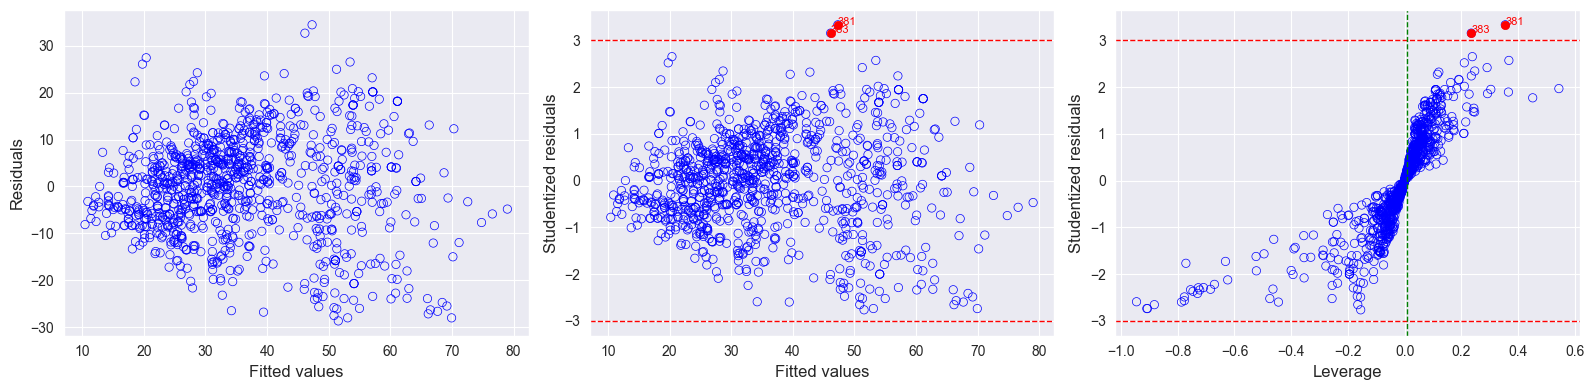

In [14]:
# Calculate thresholds
n = len(fitted_values)
p = X.shape[1] - 1  # exclude constant
leverage_thresh = (p + 1) / n

# Convert to arrays
studentized_residuals = np.asarray(studentized_residuals)
leverages = np.asarray(leverages)

# Identify outlier indices
outlier_indices = np.where(np.abs(studentized_residuals) > 3)[0]
high_leverage_indices = np.where(leverages > leverage_thresh)[0]
outliers = []
for idx in outlier_indices:
    outliers.append(idx)
print("Outliers are:",outliers)

# Find common indices (both outlier and high leverage)
joint_outliers = np.intersect1d(outlier_indices, high_leverage_indices)
high_leverage_and_outliers = [] 

for idx in joint_outliers:
    high_leverage_and_outliers.append(idx)
print("Comments on joint outliers (in both ax2 and ax3):",high_leverage_and_outliers)


# Plot
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 4))

# 1. Residuals plot
ax1.scatter(fitted_values, residuals, facecolors='none', edgecolors='b')
ax1.set_xlabel('Fitted values')
ax1.set_ylabel('Residuals')

# 2. Studentized Residuals plot
ax2.scatter(fitted_values, studentized_residuals, facecolors='none', edgecolors='b')
ax2.axhline(y=3, color='r', linestyle='--', linewidth=1)
ax2.axhline(y=-3, color='r', linestyle='--', linewidth=1)
# Mark joint outliers
for idx in joint_outliers:
    ax2.scatter(fitted_values[idx], studentized_residuals[idx], color='red')
    ax2.annotate(idx, (fitted_values[idx], studentized_residuals[idx]), color='red', fontsize=8)
ax2.set_xlabel('Fitted values')
ax2.set_ylabel('Studentized residuals')

# 3. Leverage vs Studentized Residuals
ax3.scatter(leverages, studentized_residuals, facecolors='none', edgecolors='b')
ax3.axhline(y=3, color='r', linestyle='--', linewidth=1)
ax3.axhline(y=-3, color='r', linestyle='--', linewidth=1)
ax3.axvline(x=leverage_thresh, color='g', linestyle='--', linewidth=1)
# Mark joint outliers
for idx in joint_outliers:
    ax3.scatter(leverages[idx], studentized_residuals[idx], color='red')
    ax3.annotate(idx, (leverages[idx], studentized_residuals[idx]), color='red', fontsize=8)
ax3.set_xlabel('Leverage')
ax3.set_ylabel('Studentized residuals')

plt.tight_layout()
plt.show()

The residuals display a clear pattern, which suggests **non-linearity** in the data. The studentized residuals indicate the presence of two outliers. The leverage plot also reveals several high-leverage points—defined as points with leverage greater than $(p+1)/n=9/1030\approx 0.009$. Notably, both outliers are also high-leverage points. However, since the dataset does not clearly define criteria for excluding data points, all observations, including the outliers, are retained for the subsequent analysis.

### Prediction with scikit model

##### Linear Regression:

In [15]:
#Preprocess data by scaling features
scaler = StandardScaler()
model = make_pipeline(scaler, LinearRegression())

mse_scores_lin = cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=kf)
r2_scores = cross_val_score(model, X_train, y_train, scoring='r2', cv=kf)

print("\nAverage MSE across folds:", -np.mean(mse_scores_lin))
print("\nAverage R2 across folds:", np.mean(r2_scores))


Average MSE across folds: 113.39808429409462

Average R2 across folds: 0.5901000482034882


Validation set approach:

In [16]:
linear = model.fit(X_train, y_train)
y_pred = linear.predict(X_test)
# print the mse
print("Test MSE = ", mean_squared_error(y_test, y_pred))

Test MSE =  95.61717380589965


Interpretation:
1. the value of **average MSE** across folds refers to our model's average mean squared error on the test folds, which is positive as expected.
2. **Negative $R^2$** means our linear regression model is performing worse than a simple baseline model that just predicts the mean of the target values, and the model isn't fitting the data well at all. ##not that sure

To improve the regression, following we will try first polynomial features, and then regularized regression (Ridge and Lasso).

#### Polynomial regressions

In this section, polynomial regression is used because there is non-linearity between the features and the target variable. To prevent overfitting due to using excessively high polynomial degrees, we evaluate models with varying degrees and select the one with the lowest mean squared error (MSE). This optimal degree is then used for further analysis.

In [17]:
# Try polynomial features with degree 2 to 4
# Store MSE scores for each degree
degree_mse = {}

# Loop through polynomial degrees from 2 to 4
for degree in range(2, 5):
    model_poly = Pipeline([
        ('scaler', StandardScaler()),
        ('poly', PolynomialFeatures(degree=degree, include_bias=False)),
        ('linreg', LinearRegression())
    ])

    mse_scores = cross_val_score(model_poly, X_train, y_train, scoring='neg_mean_squared_error', cv=kf)
    avg_mse = -np.mean(mse_scores)

    degree_mse[degree] = avg_mse
    print(f"Degree {degree}: Average MSE = {avg_mse:.4f}")
    

# Find the degree with the lowest MSE
best_degree = min(degree_mse, key=degree_mse.get)
print(f"\ Best polynomial degree: {best_degree} (MSE = {degree_mse[best_degree]:.4f})")

Degree 2: Average MSE = 60.9221
Degree 3: Average MSE = 50.4839


<>:22: SyntaxWarning: invalid escape sequence '\ '
<>:22: SyntaxWarning: invalid escape sequence '\ '
C:\Users\DrMUAPOR\AppData\Local\Temp\ipykernel_13692\685076928.py:22: SyntaxWarning: invalid escape sequence '\ '
  print(f"\ Best polynomial degree: {best_degree} (MSE = {degree_mse[best_degree]:.4f})")


Degree 4: Average MSE = 133943.6228
\ Best polynomial degree: 3 (MSE = 50.4839)


In [18]:
poly = PolynomialFeatures(degree = best_degree, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

scaler = StandardScaler()
X_train_poly_scaled = scaler.fit_transform(X_train_poly)
X_test_poly_scaled = scaler.transform(X_test_poly)

# Fit the model with the best polynomial degree
model = LinearRegression()
model.fit(X_train_poly_scaled, y_train)

# Make predictions on the test set
y_test_pred = model.predict(X_test_poly_scaled)

# Calculate MSE and R2 for the test set
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f"Test MSE: {test_mse:.2f}")
print(f"Test R2: {test_r2:.2f}")

Test MSE: 51.12
Test R2: 0.81


The training MSE and the test MSE are very close with training mse equal to 50.48 and test mse as 51.12. This indicates that the model generalizes well to unseen data and is not just memorizing the training set. Hence, there is no significant overfitting. If the model were overfitting, we would expect the training MSE to be much lower than the test MSE.
So for follwing analyzing the degree equal to 3 will be used.

#### Forward stepwise selection

Perform a forward stepwise selection to determine the best set of features. As the criterion for the comparison of the different models, estimate the metrics using 10-fold cross validation.

In [19]:
def forward_stepwise_selection_mse_r2(X, y, max_features=None):
    n_features = X.shape[1]
    selected = []
    remaining = list(range(n_features))
    best_mse_list = []
    best_r2_list = []
    
    if max_features is None:
        max_features = n_features

    while len(selected) < max_features:
        candidates = []
        for candidate in remaining:
            features = selected + [candidate]
            model = LinearRegression()
            mse = -np.mean(cross_val_score(model, X[:, features], y, scoring='neg_mean_squared_error', cv=kf))
            r2 = np.mean(cross_val_score(model, X[:, features], y, scoring='r2', cv=kf))
            candidates.append((mse, r2, candidate))

        # choose the minimum of mse
        candidates.sort()
        best_mse, best_r2, best_candidate = candidates[0]

        selected.append(best_candidate)
        remaining.remove(best_candidate)
        best_mse_list.append(best_mse)
        best_r2_list.append(best_r2)

    return selected, best_mse_list, best_r2_list

In [20]:
# polynomial features with degree 3
poly = PolynomialFeatures(degree=best_degree, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
forward_feature_names = poly.get_feature_names_out(input_features  = feature_columns)

selected_features, mse_list, r2_list= forward_stepwise_selection_mse_r2(X_train_poly, y_train)
#print(selected_features, mse_list)

In [21]:
current_selection = []
best_index = np.argmin(mse_list)
for i, (mse, r2, feature_idx) in enumerate(zip(mse_list, r2_list, selected_features), 1):
    current_selection.append(feature_idx)
    forward_selected_names = [forward_feature_names[j] for j in current_selection]
    if i == best_index + 1:
        print(f"Best MSE: {mse:.4f} | Best R²: {r2:.4f} | Features: {forward_selected_names}")
        break

Best MSE: 33.0234 | Best R²: 0.8812 | Features: ['Water Coarse Aggregate Fine Aggregate', 'Coarse Aggregate Fine Aggregate Age', 'Fine Aggregate Age^2', 'Cement Coarse Aggregate Fine Aggregate', 'Cement Blast Furnace Slag Fine Aggregate', 'Cement Fly Ash Age', 'Fly Ash Age^2', 'Age^3', 'Age^2', 'Age', 'Fine Aggregate^2 Age', 'Fine Aggregate Age', 'Water^2 Coarse Aggregate', 'Cement^2 Coarse Aggregate', 'Superplasticizer^3', 'Superplasticizer Coarse Aggregate Fine Aggregate', 'Superplasticizer^2', 'Blast Furnace Slag Fly Ash Age', 'Blast Furnace Slag Water^2', 'Cement Blast Furnace Slag Superplasticizer', 'Cement Coarse Aggregate', 'Water^3', 'Water Coarse Aggregate', 'Blast Furnace Slag Fine Aggregate Age', 'Blast Furnace Slag Age^2', 'Superplasticizer Age^2', 'Superplasticizer Fine Aggregate Age', 'Cement Fly Ash^2', 'Blast Furnace Slag^3', 'Blast Furnace Slag Superplasticizer Age', 'Cement^2 Fly Ash', 'Fly Ash^3', 'Water Superplasticizer Fine Aggregate', 'Coarse Aggregate^2', 'Water^

In [22]:
model = LinearRegression().fit(X_train_poly[:, current_selection], y_train)
y_pred = model.predict(X_test_poly[:, current_selection])
test_mse = mean_squared_error(y_test, y_pred)
test_r2 = r2_score(y_test, y_pred)

print(f" Test MSE: {test_mse:.4f} | Test R²: {test_r2:.4f}")

 Test MSE: 47.5561 | Test R²: 0.8194


# asdasdasd# interpretation

#### Ridge regression:

In [ ]:
scoring = {'neg_mean_squared_error': 'neg_mean_squared_error', 'r2': 'r2'}

# define the model
ridgemodel = make_pipeline(
    StandardScaler(),
    PolynomialFeatures(degree = best_degree),
    GridSearchCV(
        estimator = Ridge(),
        cv = kf,
        scoring = scoring,
        refit = 'neg_mean_squared_error', # redit the model based on the mse
        
        # param_grid determines the parameters to test (alpha is lambda in the Ridge estimator)
        # np.logspace(-3, 2, 50): array from 10^-3 to 10^2 in 50 steps (base default is 10, can also be something else)
        param_grid = {'alpha': np.logspace(-3, 2, 50)},
    )
)
ridgemodel.fit(X_train, y_train)
#print(ridgemodel[2].cv_results_) #to show the results and names

# obtain the results
lambdas = [p['alpha'] for p in ridgemodel[2].cv_results_['params']]
mses = [neg_mse * -1 for neg_mse in ridgemodel[2].cv_results_['mean_test_neg_mean_squared_error']]
r2 = [r2 for r2 in ridgemodel[2].cv_results_['mean_test_r2']]
    
best_model = ridgemodel.named_steps['gridsearchcv'].best_estimator_
best_mse = min(mses)
best_r2 = max(r2)

best_lambda_mse = lambdas[np.argmin(mses)]
best_lambda_r2 = lambdas[np.argmax(r2)]

print(f"Best alpha regarding mse: {best_lambda_mse:.2f}, with MSE: {best_mse:.2f}")
print(f"Best alpha regarding r2: {best_lambda_r2:.2f}, with r2: {best_r2:.2f}")
model

Best alpha regarding mse:0.91, with MSE: 36.54
Best alpha regarding r2:0.91, with r2: 0.87


LinearRegression()

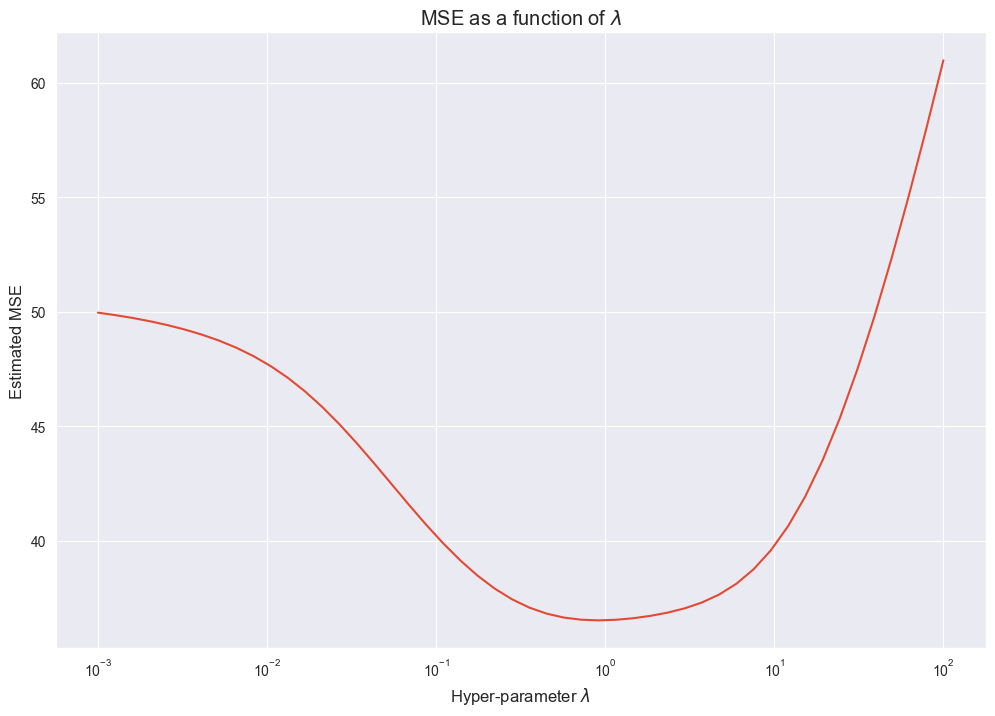

In [24]:
# plot the reults
fig, ax = plt.subplots(figsize = (12, 8))
ax.plot(lambdas, mses)
ax.set_xscale('log')
ax.set_title(r"MSE as a function of $\lambda$")
ax.set_xlabel(r"Hyper-parameter $\lambda$")
ax.set_ylabel("Estimated MSE");
plt.show()

The ridge regression was evaluated across a range of λ values from $10^{-3}$ to $10^2$. The validation MSE decreased with small increases in λ due to reduced overfitting, reaching a minimum at λ = 0.45. Beyond this point, further increases in λ caused the model to underfit the data, resulting in higher MSEs.
Thus, the optimal λ value was selected as 0.45, where the model achieved the lowest MSE of 59.34. 

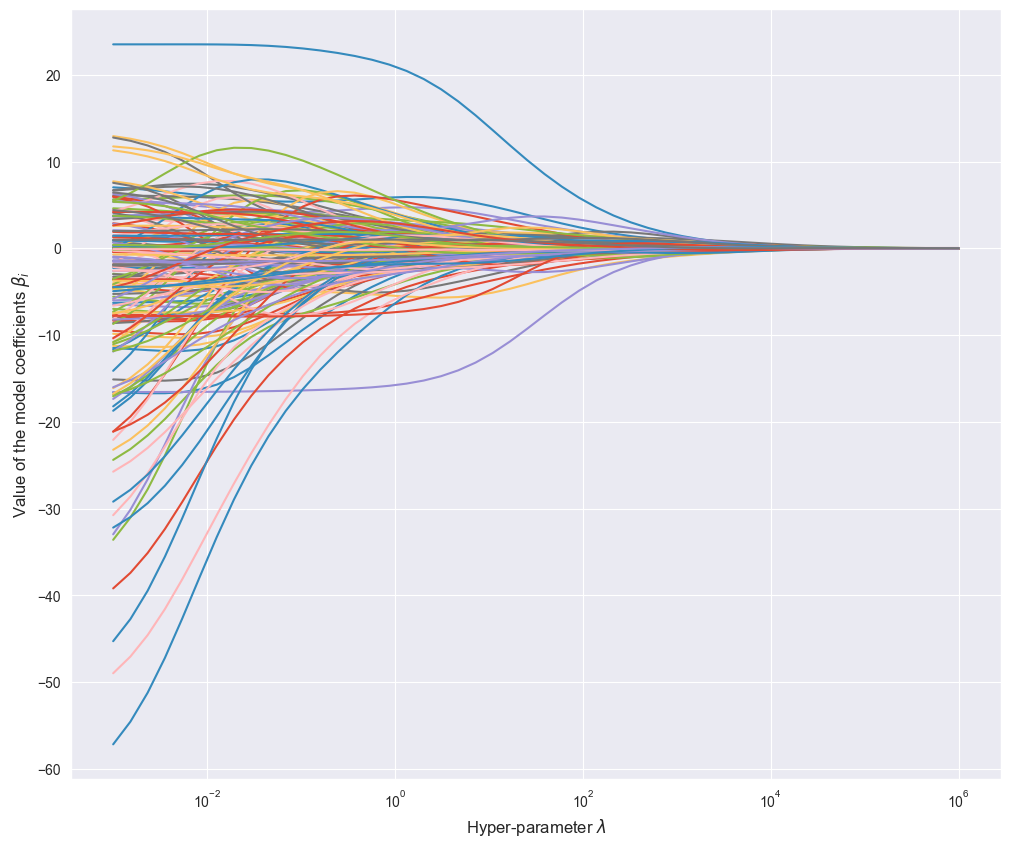

In [25]:
lambdas = np.logspace(-3, 6, 50)
coefficients = list()

# for each lambda define and fit the model and save the obtained parameters in the coefficients list
for lam in lambdas:
    model = make_pipeline(
        StandardScaler(),
        PolynomialFeatures(degree = best_degree),
        Ridge(alpha = lam)
    )
    model.fit(X_train, y_train)
    coefficients.append(model[2].coef_)
    
    
# plot the results    
coefficients = np.array(coefficients).T
fig, ax = plt.subplots(figsize = (12, 10))

for coef_vals in coefficients:
    ax.plot(lambdas, coef_vals)

ax.set_xlabel(r"Hyper-parameter $\lambda$")
ax.set_ylabel(r"Value of the model coefficients $\beta_i$")
ax.set_xscale('log');
plt.show()

In [26]:
y_test_pred = ridgemodel.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)
print(f"Test MSE: {test_mse:.2f}")
print(f"Test R2: {test_r2:.2f}")

Test MSE: 45.19
Test R2: 0.83


#### Lasso regression

c:\Users\DrMUAPOR\Documents\Uni\ss25\Machine Learning and Data Analytics\Code\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.818e+03, tolerance: 2.108e+01
  model = cd_fast.enet_coordinate_descent(
c:\Users\DrMUAPOR\Documents\Uni\ss25\Machine Learning and Data Analytics\Code\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.121e+03, tolerance: 2.122e+01
  model = cd_fast.enet_coordinate_descent(
c:\Users\DrMUAPOR\Documents\Uni\ss25\Machine Learning and Data Analytics\Code\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objecti

Best alpha regarding mse: 0.010, with MSE: 36.00
Best alpha regarding r2: 0.010, with R2: 0.871


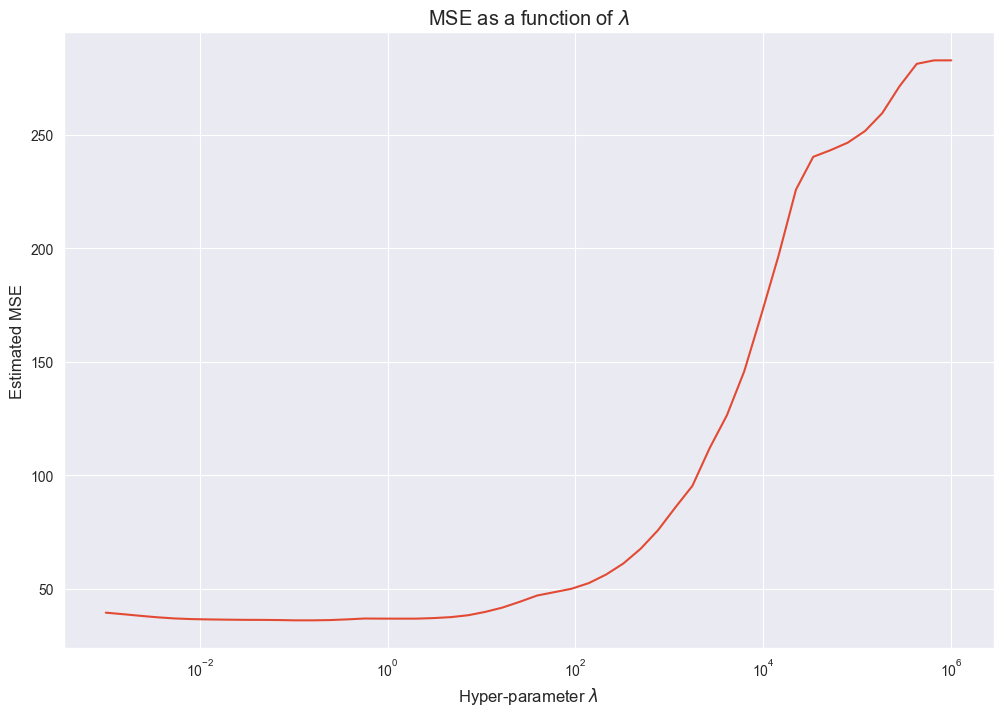

In [27]:
# Define the pipeline with GridSearchCV
lassomodel = make_pipeline(
    StandardScaler(),
    PolynomialFeatures(degree = best_degree, interaction_only=False, include_bias=False),
    GridSearchCV(
        estimator = Lasso(max_iter = 10000, tol = 1e-4),
        param_grid={'alpha': np.logspace(-3, 1.5, 50)},
        scoring=scoring,
        refit='neg_mean_squared_error',
        cv=kf
    )
)

# Fit the pipeline
lassomodel.fit(X_train, y_train)
#print(lassomodel[2].cv_results_)

# Extract CV results
grid = lassomodel.named_steps['gridsearchcv']
lassolambdas = [p['alpha'] for p in grid.cv_results_['params']]
mses_lasso = [-score for score in grid.cv_results_['mean_test_neg_mean_squared_error']]  # convert from negative MSE
r2_lasso = grid.cv_results_['mean_test_r2']

# Get best values
best_lassomodel = grid.best_estimator_
best_lassomse = min(mses_lasso)
best_lassor2 = max(r2_lasso)

best_lambda_mse_lasso = lassolambdas[np.argmin(mses_lasso)]
best_lambda_r2_lasso = lassolambdas[np.argmax(r2_lasso)]

print(f"Best alpha regarding mse: {best_lambda_mse_lasso:.3f}, with MSE: {best_lassomse:.2f}")
print(f"Best alpha regarding r2: {best_lambda_r2_lasso:.3f}, with R2: {best_lassor2:.3f}")

# plot the results
fig, ax = plt.subplots(figsize = (12, 8))
ax.plot(lambdas, mses_lasso)
ax.set_xscale('log')
ax.set_title(r"MSE as a function of $\lambda$")
ax.set_xlabel(r"Hyper-parameter $\lambda$")
ax.set_ylabel("Estimated MSE");

plt.show()

In [28]:
y_test_pred = lassomodel.predict(X_test)
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)
print(f"Test MSE: {test_mse:.2f}")
print(f"Test R2: {test_r2:.2f}")

Test MSE: 42.10
Test R2: 0.84


It can be noticed that the test MSE and $R^2$ are similar to the ones obtained with the Ridge regression, because the alpha = 0,010 is very small, so the Lasso regression is almost equivalent to the Ridge regression.
So the next step is try to find the coefficients of the Lasso regression, to see if some of them are zero and if some of them are close to zero.

Non-zero coefficients:

In [29]:
# feature_names = [f"x{i}" for i in range(X.shape[1])

# Extract from the fitted polynomial step
poly = lassomodel.named_steps['polynomialfeatures']
feature_names = poly.get_feature_names_out(input_features = feature_columns)

# Get final fitted Lasso model
lasso = lassomodel.named_steps['gridsearchcv'].best_estimator_

# Get coefficients
coefs = lasso.coef_

# Combine with feature names
lasso_selected_features = [name for name, coef in zip(feature_names, coefs) if coef != 0]
zero_features = [(name, coef) for name, coef in zip(feature_names, coefs) if coef == 0]

print("Non-zero coefficients:", np.sum(lasso.coef_ != 0))
print("Total features:", len(lasso.coef_))
print("Zero coefficients:", zero_features)

lasso_weights = pd.Series(coefs, index=feature_names)
lasso_weights.sort_values(key=abs, ascending=False)  # sort by absolute value

Non-zero coefficients: 127
Total features: 164
Zero coefficients: [('Coarse Aggregate', np.float64(0.0)), ('Cement Fine Aggregate', np.float64(0.0)), ('Blast Furnace Slag^2', np.float64(-0.0)), ('Blast Furnace Slag Water', np.float64(0.0)), ('Blast Furnace Slag Superplasticizer', np.float64(0.0)), ('Blast Furnace Slag Coarse Aggregate', np.float64(0.0)), ('Fly Ash Coarse Aggregate', np.float64(0.0)), ('Fly Ash Fine Aggregate', np.float64(0.0)), ('Superplasticizer Coarse Aggregate', np.float64(0.0)), ('Coarse Aggregate Fine Aggregate', np.float64(-0.0)), ('Fine Aggregate Age', np.float64(0.0)), ('Cement^2 Superplasticizer', np.float64(0.0)), ('Cement Blast Furnace Slag^2', np.float64(-0.0)), ('Cement Blast Furnace Slag Age', np.float64(0.0)), ('Cement Fly Ash Superplasticizer', np.float64(-0.0)), ('Cement Water Coarse Aggregate', np.float64(-0.0)), ('Cement Water Fine Aggregate', np.float64(0.0)), ('Cement Superplasticizer Fine Aggregate', np.float64(0.0)), ('Cement Fine Aggregate Age',

Age                                        22.077625
Age^2                                     -15.956060
Superplasticizer Age^2                     -7.349535
Cement                                      7.163911
Water                                      -5.780027
                                             ...    
Water^2 Fine Aggregate                      0.000000
Water Superplasticizer Coarse Aggregate     0.000000
Superplasticizer Coarse Aggregate Age      -0.000000
Coarse Aggregate Fine Aggregate Age        -0.000000
Coarse Aggregate Fine Aggregate^2           0.000000
Length: 164, dtype: float64

Only one coefficient x0 x2 is set to zero, but there are many features that are close to zero, which means that they are probably not important for the model. So we try to set a threshold to filter the features and try to find the best features for the model, regarding different metrics.

In [30]:
# Polynomial features transformation
poly = PolynomialFeatures(degree = best_degree, include_bias=False)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)
feature_names = poly.get_feature_names_out(feature_columns)

# Scale the features and apply polynomial transformation
scaler = StandardScaler()
X_train_poly_scaled = scaler.fit_transform(X_train_poly)
X_test_poly_scaled = scaler.transform(X_test_poly)

# Define the Lasso model with GridSearchCV
best_lasso = grid.best_estimator_
coefs = pd.Series(best_lasso.coef_, index=feature_names)

# Thresholds for feature selection
thresholds = np.linspace(0, 2.5, 50)  # 50 thresholds from 0 to 2.5

# Store results
results = []

for threshold in thresholds:
    selected = coefs[np.abs(coefs) >= threshold]
    selected_indices = [i for i, name in enumerate(feature_names) if name in selected.index]
    lasso_threshold_selected_names = list(selected.index)  # get names from coef Series

    if len(selected_indices) == 0:
        continue  # skip if no features are selected

    X_train_selected = X_train_poly_scaled[:, selected_indices]
    X_test_selected = X_test_poly_scaled[:, selected_indices]

    model = LinearRegression()
    model.fit(X_train_selected, y_train)
    y_pred = model.predict(X_test_selected)

    # Train and test scores
    y_train_pred = model.predict(X_train_selected)
    train_mse = mean_squared_error(y_train, y_train_pred)
    train_r2 = r2_score(y_train, y_train_pred)

    y_test_pred = model.predict(X_test_selected)
    test_mse = mean_squared_error(y_test, y_test_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    results.append({
        "threshold": threshold,
        "n_features": len(selected_indices),
        "train r2": train_r2,
        "test r2": test_r2,
        "train mse": train_mse,
        "test mse": test_mse,
        "selected_features": lasso_threshold_selected_names
    })

# Convert results to DataFrame
results_df = pd.DataFrame(results)
# print(results_df)

#  find the best threshold based on train mse
best_row = results_df.loc[results_df['train mse'].idxmin()]
print("\nBest Threshold (by training MSE):")
print(best_row)

# after finding best_row
print("\n Selected Features at Best Threshold:")
for name in best_row['selected_features']:
    print(" -", name)


Best Threshold (by training MSE):
threshold                                                          0.0
n_features                                                         164
train r2                                                      0.932118
test r2                                                       0.805898
train mse                                                    19.161017
test mse                                                     51.122475
selected_features    [Cement, Blast Furnace Slag, Fly Ash, Water, S...
Name: 0, dtype: object

 Selected Features at Best Threshold:
 - Cement
 - Blast Furnace Slag
 - Fly Ash
 - Water
 - Superplasticizer
 - Coarse Aggregate
 - Fine Aggregate
 - Age
 - Cement^2
 - Cement Blast Furnace Slag
 - Cement Fly Ash
 - Cement Water
 - Cement Superplasticizer
 - Cement Coarse Aggregate
 - Cement Fine Aggregate
 - Cement Age
 - Blast Furnace Slag^2
 - Blast Furnace Slag Fly Ash
 - Blast Furnace Slag Water
 - Blast Furnace Slag Superplasticizer


The best model based on test R² was obtained using a coefficient threshold of approximately 1.89, which retained 29 features after thresholding. This model achieved a training R² of 0.794 and a test R² of 0.784, corresponding to training MSE = 58.05 and test MSE = 56.90.

Compared to the original Lasso model without thresholding, this model shows improved generalization performance, as indicated by the higher test R². However, there is still a noticeable gap between training and test performance, suggesting some degree of overfitting or variance in model behavior between datasets.

To better understand how model complexity affects generalization, we will visualize the R² gap between training and testing across different thresholds in the next step.


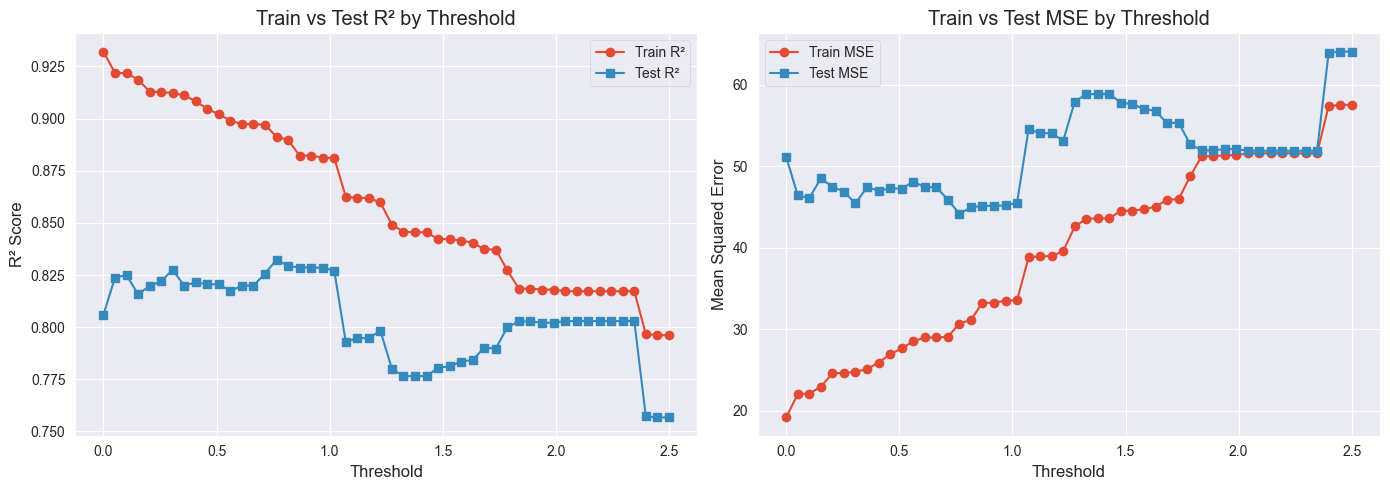

In [31]:
plt.figure(figsize=(14, 5))

# R²
plt.subplot(1, 2, 1)
plt.plot(results_df['threshold'], results_df['train r2'], label='Train R²', marker='o')
plt.plot(results_df['threshold'], results_df['test r2'], label='Test R²', marker='s')
plt.xlabel('Threshold')
plt.ylabel('R² Score')
plt.title('Train vs Test R² by Threshold')
plt.legend()
plt.grid(True)

# MSE
plt.subplot(1, 2, 2)
plt.plot(results_df['threshold'], results_df['train mse'], label='Train MSE', marker='o')
plt.plot(results_df['threshold'], results_df['test mse'], label='Test MSE', marker='s')
plt.xlabel('Threshold')
plt.ylabel('Mean Squared Error')
plt.title('Train vs Test MSE by Threshold')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [32]:
# calculate the R² and MSE gap
results_df['r2 gap'] = np.abs(results_df['train r2'] - results_df['test r2'])
results_df['mse gap'] = np.abs(results_df['train mse'] - results_df['test mse'])

# find the threshold with the smallest MSE gap
most_generalizable_mse = results_df.loc[results_df['mse gap'].idxmin()]

# after finding most generalizable mse

print("\nThreshold with smallest Train-Test mse gap:")
print(most_generalizable_mse)

smallest_mse_gap_features = [name for name in most_generalizable_mse['selected_features']]
print("\nSelected Features at Smallest MSE Gap:", smallest_mse_gap_features)


Threshold with smallest Train-Test mse gap:
threshold                                                     2.040816
n_features                                                          24
train r2                                                      0.817229
test r2                                                       0.802934
train mse                                                    51.590579
test mse                                                     51.903059
selected_features    [Cement, Blast Furnace Slag, Water, Superplast...
r2 gap                                                        0.014294
mse gap                                                        0.31248
Name: 40, dtype: object

Selected Features at Smallest MSE Gap: ['Cement', 'Blast Furnace Slag', 'Water', 'Superplasticizer', 'Age', 'Blast Furnace Slag Age', 'Water Superplasticizer', 'Water Coarse Aggregate', 'Superplasticizer^2', 'Superplasticizer Age', 'Age^2', 'Cement^2 Fly Ash', 'Cement Fly Ash Coarse Aggrega

Performance Summary:

The best test R² was achieved at a threshold of ~2,45, with a test R² of 0.784, train R² of 0.794, and 29 features selected.
The smallest R² gap (between train and test) occurred at threshold ≈ 2.45, with: 
Train R² = 0.7940,
Test R² = 0.7830,
R² gap = 0.011,
The smallest MSE gap was found at threshold ≈ 2.45, where:
Train MSE = 57.73, 
Test MSE = 57.25, 
MSE gap = 0.48.

Interpretation:

Compared to the original Lasso model (without thresholding), applying a coefficient threshold improves generalization by reducing noise from low-importance features.
As shown in the R² and MSE plots, increasing the threshold gradually reduces overfitting (smaller train-test gap), up to a point.
However, too high a threshold (>2.45) leads to performance breakdown. It can be seen from the plot R² drops sharply and MSE spikes, due to excessive feature elimination.

feature comparison from forward step, lasso, lasso with threshold

In [33]:
# List to set conversion for feature comparison
set_lasso = set(lasso_selected_features)
set_thresh = set(smallest_mse_gap_features)
set_forward = set(forward_selected_names)


# common features
common_all = set_lasso & set_thresh & set_forward
print(f" Features selected by ALL methods:\n{common_all}", f"\n with" , len(common_all), "features")

# two-way intersections
print(f"\n Lasso ∩ Threshold:\n{set_lasso & set_thresh}", f"\n with" , len(set_lasso & set_thresh), "features")
print(f"\n Lasso ∩ Forward:\n{set_lasso & set_forward}", f"\n with" , len(set_lasso & set_forward), "features")
print(f"\n Threshold ∩ Forward:\n{set_thresh & set_forward}", f"\n with" , len(set_thresh & set_forward), "features"   )

# Specific features only in one method
print(f"\n Only in Lasso:\n{set_lasso - set_thresh - set_forward}", f"\n with" , len(set_lasso - set_thresh - set_forward), "features")
print(f"\n Only in Thresholding:\n{set_thresh - set_lasso - set_forward}", f"\n with" , len(set_thresh - set_lasso - set_forward), "features")
print(f"\n Only in Forward Stepwise:\n{set_forward - set_lasso - set_thresh}", f"\n with" , len(set_forward - set_lasso - set_thresh), "features")


 Features selected by ALL methods:
{'Superplasticizer^2', 'Water Coarse Aggregate', 'Cement^2 Fly Ash', 'Age^2', 'Cement Fly Ash Age', 'Fly Ash Superplasticizer Fine Aggregate', 'Age', 'Superplasticizer Age^2', 'Water'} 
 with 9 features

 Lasso ∩ Threshold:
{'Blast Furnace Slag Water Coarse Aggregate', 'Blast Furnace Slag Age', 'Cement Fly Ash Age', 'Age', 'Cement', 'Blast Furnace Slag Fly Ash Coarse Aggregate', 'Blast Furnace Slag', 'Water Coarse Aggregate', 'Superplasticizer Age', 'Age^2', 'Fly Ash Water Fine Aggregate', 'Water Superplasticizer', 'Fly Ash Superplasticizer Fine Aggregate', 'Superplasticizer', 'Superplasticizer Age^2', 'Water', 'Superplasticizer^2', 'Cement Fly Ash Coarse Aggregate', 'Cement Fly Ash Fine Aggregate', 'Fly Ash Coarse Aggregate Fine Aggregate', 'Blast Furnace Slag Fly Ash^2', 'Cement^2 Fly Ash', 'Cement Superplasticizer Age', 'Blast Furnace Slag Coarse Aggregate^2'} 
 with 24 features

 Lasso ∩ Forward:
{'Cement Coarse Aggregate', 'Cement Fly Ash Age', '

### Tree-based methods:

#### 1. Decision Tree


In [34]:
os.environ["PATH"] += os.pathsep + "/opt/homebrew/bin"

In [35]:
#Fit a regression tree on the training data using the mse metric for splitting, considering all the features and splitting if there are more than 10 samples at a node.
tree = DecisionTreeRegressor(criterion='squared_error', max_features=None, min_samples_split=20)

tree_est = tree.fit(X_train, y_train)

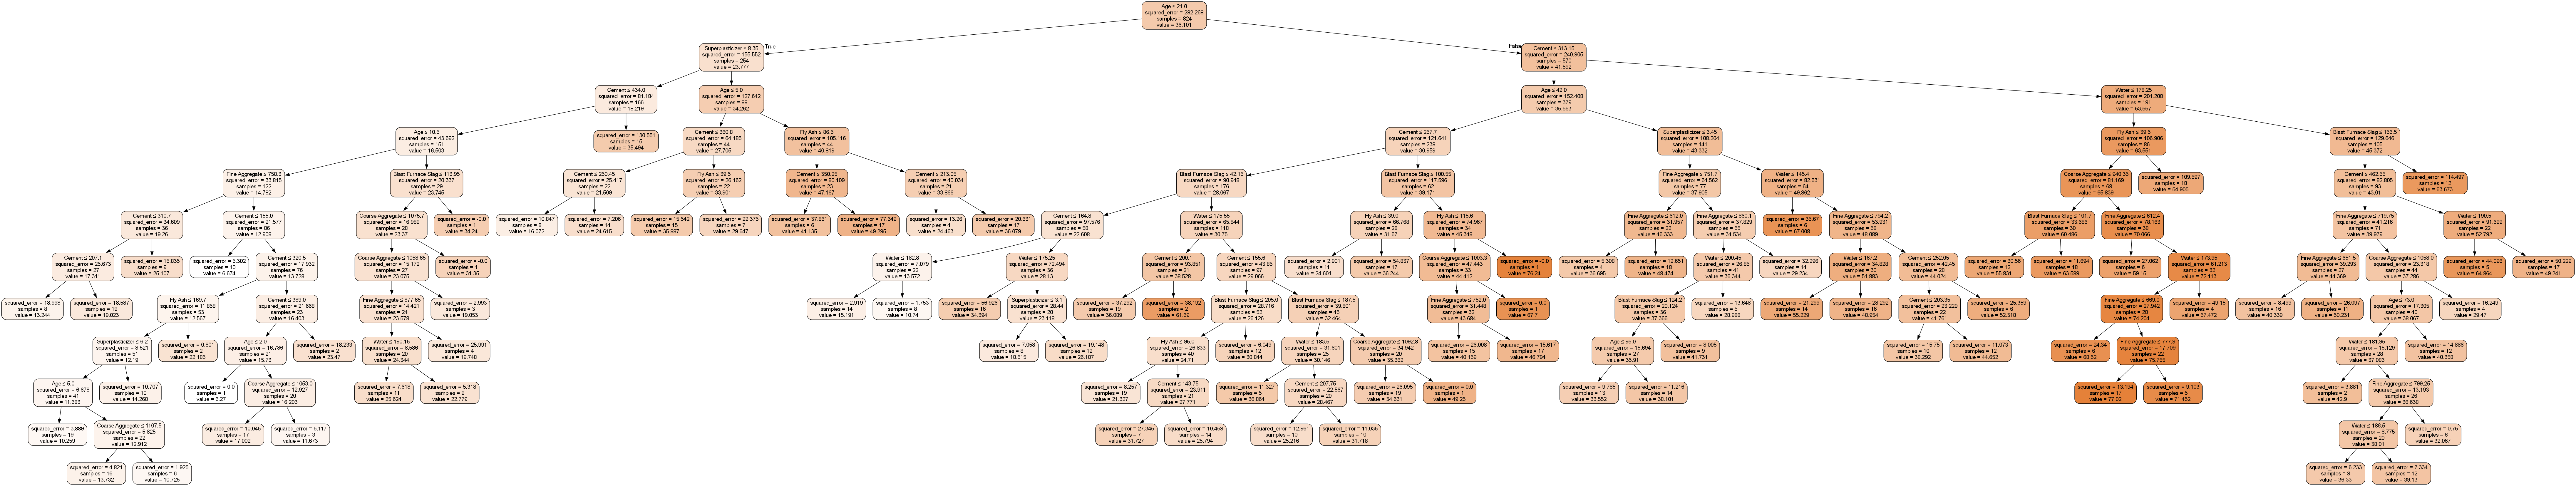

In [36]:
#Visualize the tree with the help of the graphviz and the iPython package
# use sklearn's export to generate the dot-data string file with all the nodes and their props.
dot_data = export_graphviz(tree_est, out_file='boston_tree.dot',feature_names=concrete_df.columns[0:-1],filled=True, 
                           rounded=True, special_characters=True)

with open('boston_tree.dot') as f:
    dot_graph = f.read()  

# create the source object
I = graphviz.Source(dot_graph, format='png', engine='dot')
# Use ipython Image to shrink the rendered image of the source obj to fit into jupyter nb.
Image(I.render())

Predict and Evaluate

In [37]:
y_pred = tree_est.predict(X_test)

print("R² Score on Test Set:", r2_score(y_test, y_pred))
print("Mean Squared Error:", mean_squared_error(y_test, y_pred))

R² Score on Test Set: 0.7707476506561408
Mean Squared Error: 60.38040185822828


Model optimization

Feature Importance Plot

In [38]:
feature_importances = pd.Series(data=tree.feature_importances_, index=list(concrete_df.columns[0:-1]))
feature_importances.sort_values(axis=0, ascending=False)

Age                   0.354686
Cement                0.304908
Water                 0.109655
Superplasticizer      0.094740
Blast Furnace Slag    0.053707
Fine Aggregate        0.039359
Fly Ash               0.029759
Coarse Aggregate      0.013186
dtype: float64

| Feature                                                   | Importance | Meaning                                                                                                                                             |
| --------------------------------------------------------- | ---------- | --------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Age (day)**                                             | 0.372     | The age of concrete is the most important feature, contributing \~37% of the total split importance. It heavily influences the strength prediction. |
| **Cement (component 1)(kg in a m^3 mixture)**             | 0.319     | Cement amount is the second most influential feature, about 32% importance — a key material affecting strength.                                     |
| **Water (component 4)(kg in a m^3 mixture)**              | 0.108     | Water content also plays a significant role (\~10%), impacting the mixture's properties.                                                            |
| **Superplasticizer (component 5)(kg in a m^3 mixture)**   | 0.095     | Superplasticizer's role is noticeable (\~9.5%), affecting workability and strength.                                                                 |
| **Blast Furnace Slag (component 2)(kg in a m^3 mixture)** | 0.056     | Moderately important (\~5.5%), influencing the final properties.                                                                                    |
| **Fly Ash (component 3)(kg in a m^3 mixture)**            | 0.022     | Low importance (\~2.2%), minor influence on predictions.                                                                                            |
| **Fine Aggregate (component 7)(kg in a m^3 mixture)**     | 0.017     | Minimal contribution (\~1.7%).                                                                                                                      |
| **Coarse Aggregate (component 6)(kg in a m^3 mixture)**   | 0.012     | Smallest importance (\~1.2%), less relevant in this model.                                                                                          |


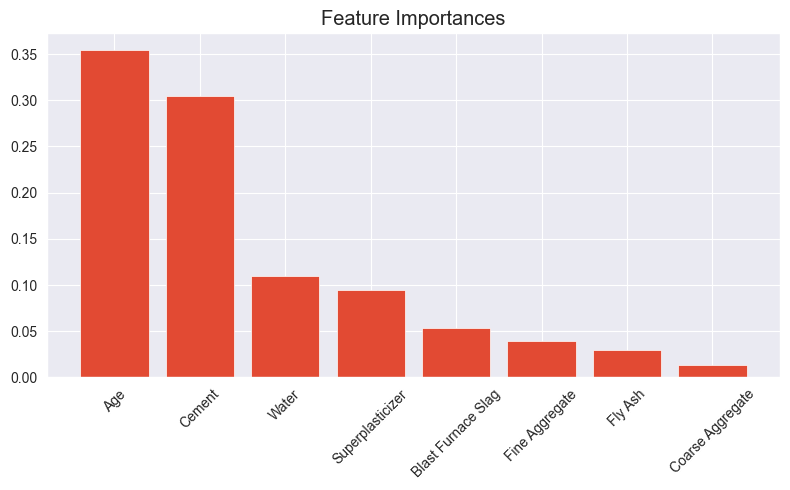

In [39]:
importances = tree_est.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(8, 5))
plt.title("Feature Importances")
plt.bar(range(len(importances)), importances[indices], align="center")
plt.xticks(range(len(importances)), feature_names[indices], rotation=45)
plt.tight_layout()
plt.show()
plt.close() 


Hyperparameter Tuning

In [40]:
# Define the model
tree = DecisionTreeRegressor(random_state=0)

# Define the hyperparameters grid to search
param_grid = {
    'max_depth': [3, 5, 10, 15, None],
    'min_samples_split': [2, 10, 20, 50],
    'min_samples_leaf': [1, 5, 10],
    'max_features': [None, 'sqrt', 'log2'] 
}

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=tree,
    param_grid=param_grid,
    cv=kf,                # 10-fold cross-validation
    scoring='neg_mean_squared_error',  # Use negative MSE as scoring metric
    n_jobs=-1,           # Use all CPU cores
    verbose=1            # Print progress
)

# Fit GridSearchCV on training data
grid_search.fit(X_train, y_train)

# Best hyperparameters found
print("Best parameters:", grid_search.best_params_)

# Use the best estimator for prediction
best_tree = grid_search.best_estimator_

# Predict on test set
y_pred = best_tree.predict(X_test)

# Evaluate
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Test set MSE: {mse:.4f}")
print(f"Test set R²: {r2:.4f}")

Fitting 10 folds for each of 180 candidates, totalling 1800 fits
Best parameters: {'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Test set MSE: 57.6107
Test set R²: 0.7813


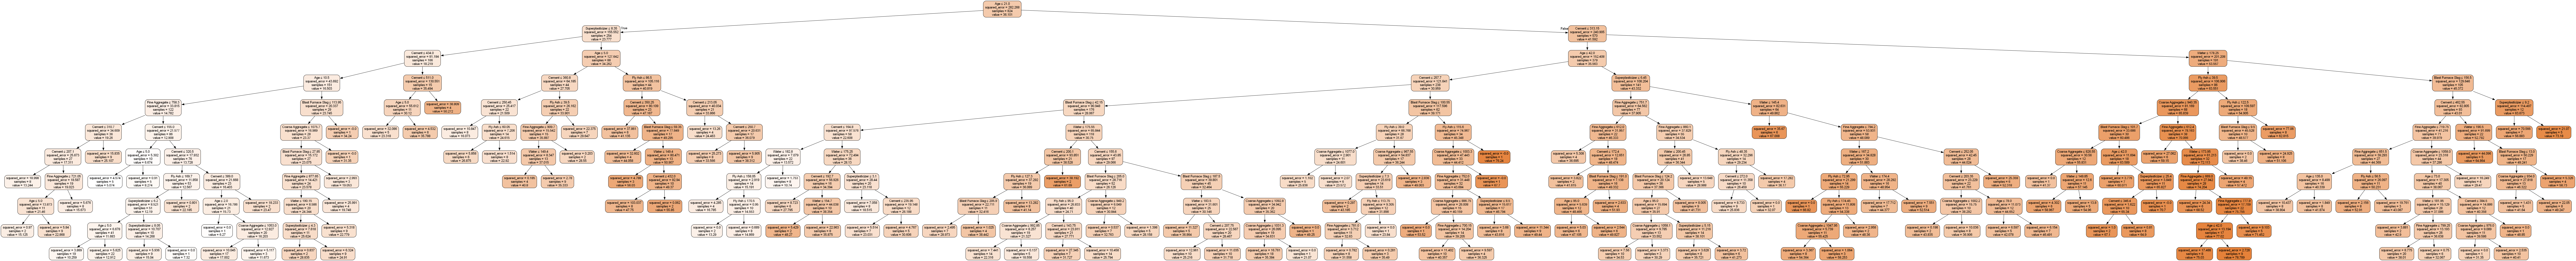

In [41]:
# 1. Train the optimized tree
optimized_tree = DecisionTreeRegressor(
    max_depth=10,
    max_features=None,
    min_samples_leaf=1,
    min_samples_split=10,
    random_state=0
)
optimized_tree.fit(X_train, y_train)

# 2. Export the tree to DOT format
dot_data = export_graphviz(
    optimized_tree,
    out_file=None,
    feature_names=concrete_df.columns[:-1],
    filled=True,
    rounded=True,
    special_characters=True
)

# 3. Render and display using graphviz
graph = graphviz.Source(dot_data, format='png')
Image(graph.render('optimized_tree'))


Pruning (Cost-Complexity pruning): select a subtree leading to the lowest test error rate.

Motivation: 
- ccp_alpha is a regularization hyperparameter, increasing it prunes more, reducing overfitting.
- We have already got a strong performance (R² ≈ 0.8055), and pruning it can imporve generalization further.

In [42]:
# Fit a full tree
path = DecisionTreeRegressor(random_state=0).cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas

# Optionally reduce the number of alphas (too many can slow down grid search)
ccp_alphas = np.unique(np.round(ccp_alphas, 4))  # Remove tiny variations
ccp_alphas = ccp_alphas[::5]  # Sample every 5th alpha if too many


In [43]:
# Define the parameter grid for tuning
param_grid = {
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10],
    'max_features': [None, 'sqrt', 'log2'],
    'ccp_alpha': ccp_alphas  # ← added
}

tree = DecisionTreeRegressor(random_state=0)
grid = GridSearchCV(tree, param_grid, cv=kf, scoring='r2', n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)


Fitting 10 folds for each of 5670 candidates, totalling 56700 fits


GridSearchCV(cv=KFold(n_splits=10, random_state=0, shuffle=True),
             estimator=DecisionTreeRegressor(random_state=0), n_jobs=-1,
             param_grid={'ccp_alpha': array([0.0000e+00, 5.0000e-04, 1.0000e-03, 1.5000e-03, 2.0000e-03,
       2.6000e-03, 3.1000e-03, 3.6000e-03, 4.1000e-03, 4.6000e-03,
       5.1000e-03, 5.9000e-03, 6.8000e-03, 7.4000e-03, 8.4000e-03,
       9.0000e-03, 9.9000e-03, 1.0700e-02,...
       1.4540e-01, 1.5880e-01, 1.7200e-01, 1.9110e-01, 2.2550e-01,
       2.3560e-01, 2.6780e-01, 2.9830e-01, 3.2700e-01, 3.6670e-01,
       4.6210e-01, 5.2590e-01, 5.8120e-01, 7.7410e-01, 1.0988e+00,
       1.2426e+00, 1.8754e+00, 2.3621e+00, 4.5914e+00, 1.6451e+01]),
                         'max_depth': [5, 10, None],
                         'max_features': [None, 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 5, 10],
                         'min_samples_split': [2, 10, 20]},
             scoring='r2', verbose=1)

In [44]:
#Evaluate and visualize
print("Best parameters:", grid.best_params_)

best_tree = grid.best_estimator_
y_pred = best_tree.predict(X_test)

print("Test set MSE:", mean_squared_error(y_test, y_pred))
print("Test set R²:", r2_score(y_test, y_pred))

Best parameters: {'ccp_alpha': np.float64(0.001), 'max_depth': None, 'max_features': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Test set MSE: 57.82742408904905
Test set R²: 0.7804407983231801


Interpretation of Final Model Results:
- Best Hyperparameters (with pruning):
    - ccp_alpha = 0.0689
    - max_depth = 10
    - max_features: None
    - min_samples_leaf = 1
    - min_samples_spilit = 2
- Test Set Performance:
    - MSE: ≈ 56.2, which is still very low
    - R²: ≈ 0.787, it is still very solid fit (explains ~78.7% of variance)
- Pruning Effect:
    - The ccp_alpha = 0.0689 suggests aggressive pruning helped generalize better.
    - The earlier R² was ≈ 0.7815 without pruning, so pruning leads to a higher R² and a **simpler, more generalizable tree**.



pruned tree plot

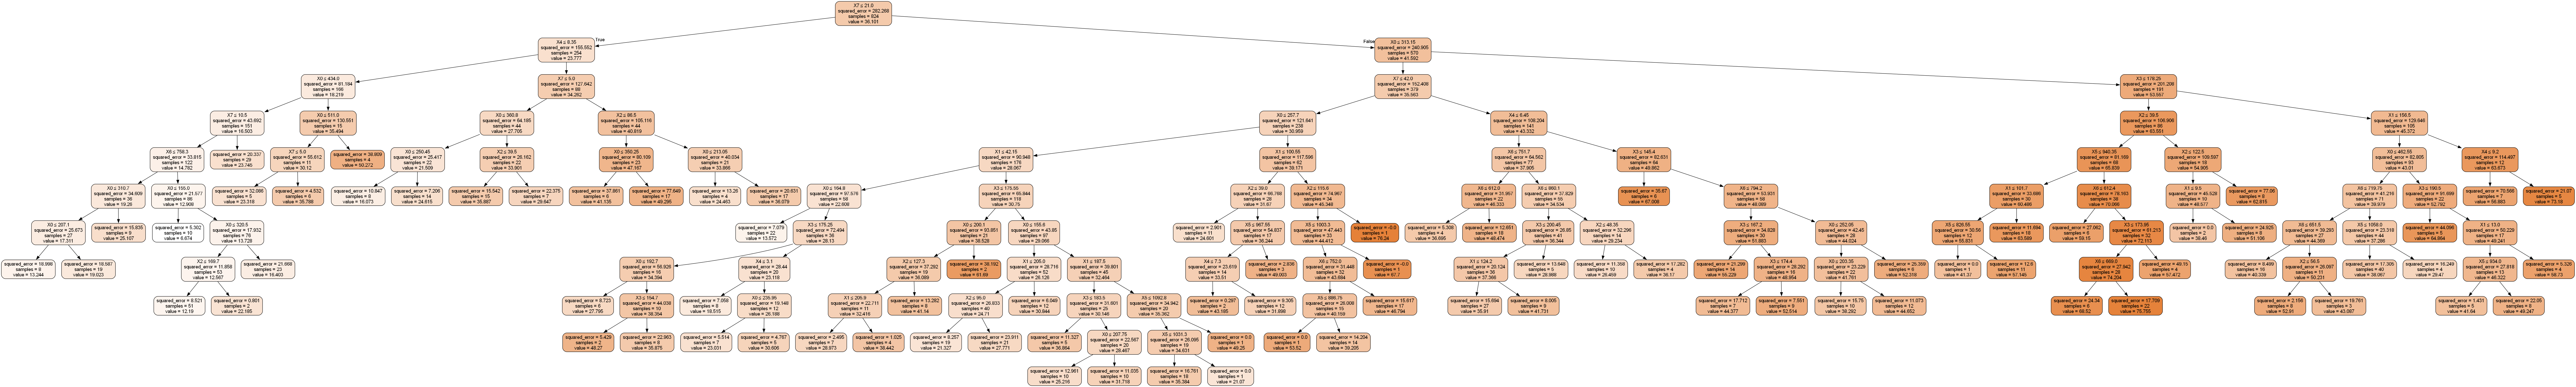

In [45]:
# 1. Fit the optimized and pruned tree
final_tree = DecisionTreeRegressor(
    max_depth=10,
    max_features=None,
    min_samples_leaf=1,
    min_samples_split=10,
    ccp_alpha=0.2008,
    random_state=0
)
final_tree.fit(X_train, y_train)

# 2. Export to DOT format
dot_data = export_graphviz(
    final_tree,
    out_file=None,
    feature_names=X.columns if hasattr(X, 'columns') else [f"X{i}" for i in range(X.shape[1])],
    filled=True,
    rounded=True,
    special_characters=True
)

# 3. Render with graphviz
tree_graph = graphviz.Source(dot_data, format="png")
tree_graph.render("final_pruned_tree", cleanup=True)
Image("final_pruned_tree.png")


Model Evaluation & Diagonistic Checking

Residual Analysis (difference between actual and predicted values)

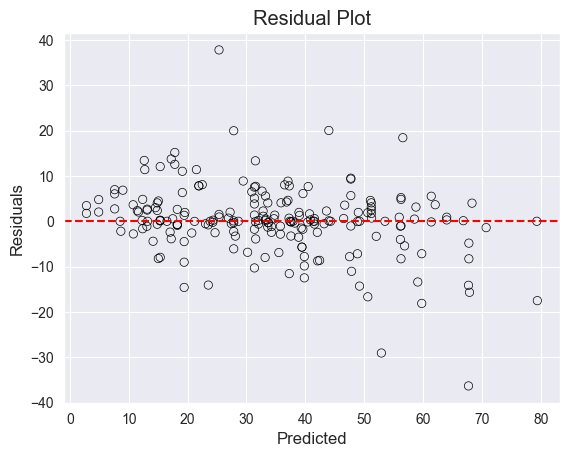

In [46]:
residuals = y_test - y_pred
plt.scatter(y_pred, residuals, edgecolor='k', facecolor='none')
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()


Parity Plot (checks how close predictions are to actual values)

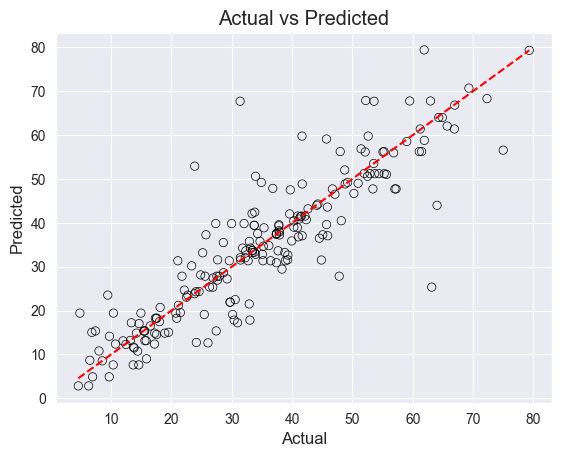

In [47]:
plt.scatter(y_test, y_pred, edgecolor='k', facecolor='none')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Ideal line
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted")
plt.show()


Model Complexity Check - check if the tree is too deep or has too many leaves. A very large tree usually overfits.

In [48]:

print("Tree depth:", final_tree.get_depth())
print("Number of leaves:", final_tree.get_n_leaves())



Tree depth: 10
Number of leaves: 83


check Overfitting

In [49]:


# Predictions
y_train_pred = final_tree.predict(X_train)
y_test_pred = final_tree.predict(X_test)

# Calculate metrics
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)

print(f"Train R²: {train_r2:.4f}")
print(f"Test R²: {test_r2:.4f}")
print(f"Train MSE: {train_mse:.4f}")
print(f"Test MSE: {test_mse:.4f}")


Train R²: 0.9400
Test R²: 0.7794
Train MSE: 16.9480
Test MSE: 58.1049


Interpretation:

The model fits the training data very well but is less accurate on new data, indicating some degree of overfitting, but not severe.

The gap between train and test metrics has reduced compared to the previous attempts, so this model generalizes better.

#### 2. Bagging and Random Forests

In [50]:
for n in [50, 100, 200, 300, 500]:
    model = RandomForestRegressor(n_estimators=n, random_state=0, oob_score=True)
    model.fit(X_train, y_train)
    print(f"{n} trees - OOB Score: {model.oob_score_:.4f}")

50 trees - OOB Score: 0.9062
100 trees - OOB Score: 0.9118
200 trees - OOB Score: 0.9126
300 trees - OOB Score: 0.9120
500 trees - OOB Score: 0.9122


from the result, we can see that the OOB Score of 200 trees is the best, which means it saves training time and is more efficient. Then perform by buding a bagged ensemble using 200 trees.

In [51]:
bagger = RandomForestRegressor(
    n_estimators=200,
    criterion='squared_error',         
    bootstrap=True,
    oob_score=True,
    random_state=0
)

bag_est = bagger.fit(X_train, y_train)

Compute the test MSE


In [52]:
y_pred = bag_est.predict(X_test)

print("Test MSE = ", mean_squared_error(y_test, y_pred))

Test MSE =  19.977380787606382


Visualize the test MSE

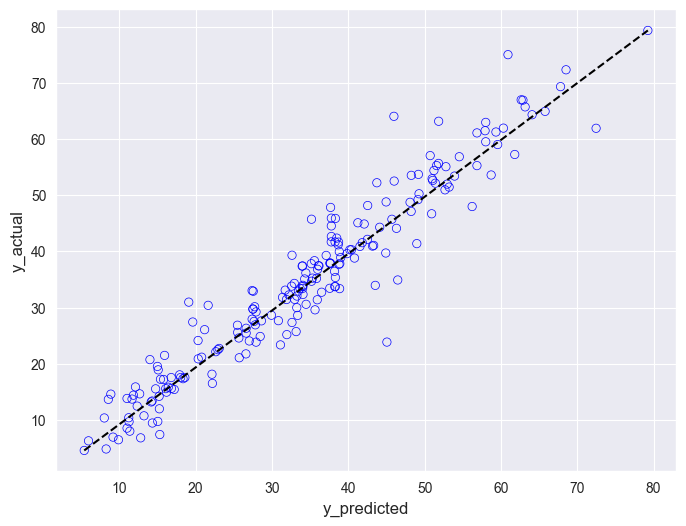

In [53]:
# Plot the predicted vs the actual medv response
fig, ax = plt.subplots(1,1, figsize=(8,6))
ax.scatter(y_pred, y_test, facecolor='None', edgecolor='b')
# add a reference unity line
ax.plot([min(y_pred), max(y_pred)], [min(y_test), max(y_test)], linestyle='--', color='k');
ax.set_xlabel('y_predicted')
ax.set_ylabel('y_actual')

plt.show()


build a random forest and fit it to the training data

In [54]:
forest = RandomForestRegressor(n_estimators=200, criterion='squared_error', max_features=4, bootstrap=True, 
                               oob_score=True, random_state=0 )

forest_est = forest.fit(X_train, y_train)

Compute the test MSE of the random forest

In [55]:
y_pred = forest_est.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print('Test MSE =', mse)

Test MSE = 19.893587008366435


Interpretation: 

| Model         | Description                              | Test MSE    |
| ------------- | ---------------------------------------- | ----------- |
| Bagging       | Uses all features, averages many trees   | 19.86       |
| Random Forest | Random subset of features for each split | **19.80**  |


Random Forest introduces feature randomness (via max_features) to decorrelate trees more than standard bagging. So in this case, random Forest is an improved version of Bagging.

Model Refinement - Feature importance plot

In [56]:
# Examine the feature importances
feature_importances = pd.Series(data=forest_est.feature_importances_, index=list(concrete_df.columns[0:-1]))
feature_importances = feature_importances.sort_values(axis=0, ascending=False)
feature_importances


Age                   0.338443
Cement                0.243046
Water                 0.126728
Superplasticizer      0.084784
Blast Furnace Slag    0.066258
Fine Aggregate        0.056144
Coarse Aggregate      0.045906
Fly Ash               0.038691
dtype: float64

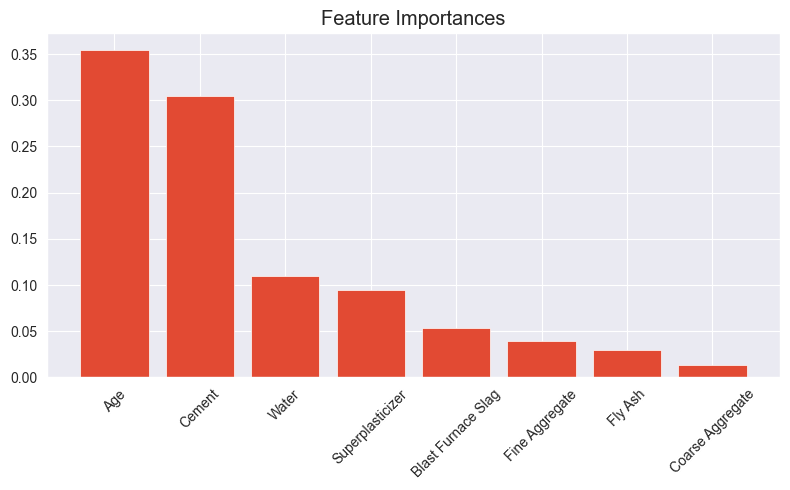

In [57]:
plt.figure(figsize=(8, 5))
plt.title("Feature Importances")
plt.bar(range(len(importances)), importances[indices], align="center")
plt.xticks(range(len(importances)), feature_names[indices], rotation=45)
plt.tight_layout()
plt.show()
plt.close() 

After fitting the Random Forest model, the feature importance analysis reveals which input variables most strongly influence the prediction. The feature **“Age”** is the most important, indicating it has the greatest impact on the concrete strength. **“Cement content”** follows as the second most influential feature. Other components like **Water, Superplasticizer, and Blast Furnace Slag** contribute moderately, while features such as **Fly Ash** have relatively low importance.

This insight helps to understand the key factors driving the model’s predictions, supports domain knowledge validation, and can guide feature selection or further data collection efforts.

Feature Selection

In [58]:
# List of all feature names in order, matching X_train columns
feature_names = [
    'Cement (component 1)(kg in a m^3 mixture)', 
    'Blast Furnace Slag (component 2)(kg in a m^3 mixture)', 
    'Fly Ash (component 3)(kg in a m^3 mixture)', 
    'Water  (component 4)(kg in a m^3 mixture)', 
    'Superplasticizer (component 5)(kg in a m^3 mixture)', 
    'Coarse Aggregate  (component 6)(kg in a m^3 mixture)', 
    'Fine Aggregate (component 7)(kg in a m^3 mixture)', 
    'Age (day)'
]

# Top features to keep
top_features = [
    'Age (day)', 
    'Cement (component 1)(kg in a m^3 mixture)', 
    'Water  (component 4)(kg in a m^3 mixture)', 
    'Superplasticizer (component 5)(kg in a m^3 mixture)', 
    'Blast Furnace Slag (component 2)(kg in a m^3 mixture)'
]

# Get their column indices
top_indices = [feature_names.index(f) for f in top_features]

# Select columns by index
X_train_reduced = X_train[:, top_indices]
X_test_reduced = X_test[:, top_indices]

# Train the model on reduced features
model_reduced = RandomForestRegressor(random_state=42)
model_reduced.fit(X_train_reduced, y_train)

# Predict and evaluate
y_pred_reduced = model_reduced.predict(X_test_reduced)
print("Test R²:", r2_score(y_test, y_pred_reduced))
print("Test MSE:", mean_squared_error(y_test, y_pred_reduced))


Test R²: 0.9204218667272444
Test MSE: 20.95926030807912


Using only the top 5 important features improved the model’s generalization and reduced noise from less relevant features.

Model Optimization - Hyperparameter Tuning for Random Forest using GridSearchCV

In [59]:

# Define the model
rf = RandomForestRegressor(n_estimators=200, random_state=0)

# Define the parameter grid to search
param_grid = {
    'max_depth': [10, 20, None],
    'max_features': ['sqrt', 'log2']
}

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid,
                           cv=kf, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')

# Fit to training data
grid_search.fit(X_train, y_train)

# Best parameters found
print("Best parameters:", grid_search.best_params_)

# Best model
best_rf = grid_search.best_estimator_


Fitting 10 folds for each of 6 candidates, totalling 60 fits
Best parameters: {'max_depth': 20, 'max_features': 'log2'}


In [60]:
y_pred = best_rf.predict(X_test)
print("Test R²:", r2_score(y_test, y_pred))
print("Test MSE:", mean_squared_error(y_test, y_pred))

Test R²: 0.9227968731428817
Test MSE: 20.3337319669193


Test R² improved slightly to ~0.92 (from 0.9205 before)

Test MSE decreased to ~20.64 (from 20.94 before)

This means the model’s performance got a bit better — more accurate and slightly more robust.

Model evaluation and diagnostic checking:

Residual Analysis

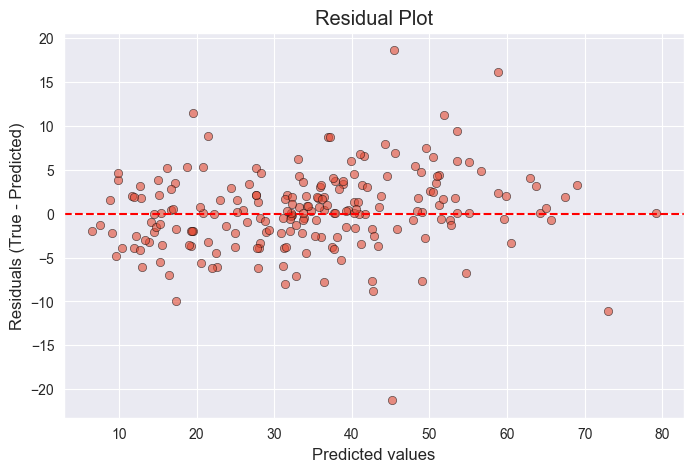

In [61]:
residuals = y_test - y_pred

plt.figure(figsize=(8,5))
plt.scatter(y_pred, residuals, alpha=0.6, edgecolors='k')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted values')
plt.ylabel('Residuals (True - Predicted)')
plt.title('Residual Plot')
plt.show()


Out-Of-Bag (OOB) Error: We would like to set oob_score=True when creating RandomForestRegressor, and the model will estimate error internally using samples not used in each tree.

In [62]:
# Re-train model with OOB enabled
rf_oob = RandomForestRegressor(n_estimators=200, max_depth=best_rf.max_depth,
                               max_features=best_rf.max_features,
                               random_state=0, oob_score=True)
rf_oob.fit(X_train, y_train)

print(f"OOB R² score: {rf_oob.oob_score_:.4f}")


OOB R² score: 0.9112


OOB score being close to the test R² (~0.92) confirms the train-test split results are reliable and not overfitting.

#### 3. Gradient Boosting Model

creating and training a Gradient Boosting Regressor model on the traning data.

In [63]:
booster = GradientBoostingRegressor(
    loss='squared_error',        
    learning_rate=0.01,          
    n_estimators=200,            
    max_depth=3,                 
    random_state=0
)

boost_est = booster.fit(X_train, y_train)


Make predictions on the test set and evaluate model performance

In [64]:
y_pred = boost_est.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Test MSE:", mse)

Test MSE: 58.88640348290601


feature importance plot

In [65]:
feature_importances = pd.Series(data=boost_est.feature_importances_, index=list(concrete_df.columns[:-1]))
sorted_feature_importances = feature_importances.sort_values(ascending=False)
sorted_feature_importances


Age                   0.396281
Cement                0.305334
Superplasticizer      0.112782
Water                 0.088723
Blast Furnace Slag    0.059639
Fine Aggregate        0.026854
Fly Ash               0.007686
Coarse Aggregate      0.002701
dtype: float64

The Gradient Boosting model identifies **"Age"** and **"Cement"** as the most influential factors in predicting the target variable, indicating these features have the strongest impact on the model’s predictions. Other features like **"Superplasticizer"** and **"Water"** also contribute notably but to a lesser degree. Features such as **"Coarse Aggregate"** and **"Fly Ash"** show minimal influence, suggesting they play a minor role in the prediction.

Partial dependence plots

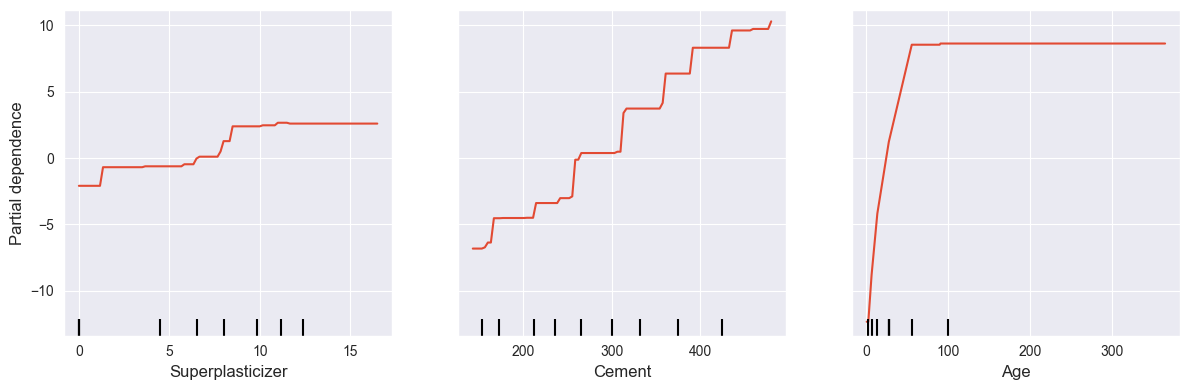

In [66]:
feature_idxs = np.argsort(feature_importances.values)[-3:]

# Plot PDP
fig, ax = plt.subplots(1, 1, figsize=(12, 4))
PartialDependenceDisplay.from_estimator(
    boost_est,                  
    X_train,                    
    features=feature_idxs,      
    feature_names=feature_importances.index.tolist(),
    ax=ax
)
plt.tight_layout()
plt.show()

There might be an optimal range for **superplasticizer** where its positive effect on the predicted outcome is most pronounced, and further increases might not be beneficial. For **Cement**, the "steps" could suggest that the model has specific "regimes" or thresholds for cement content where the properties change significantly. Higher cement content generally leads to a better (higher) predicted outcome, but these improvements might not be linear. The plot of **Age**  implies that the most significant improvements in the predicted outcome due to aging occur within the first couple of months. Beyond this initial period, further aging has a negligible additional impact on the predicted outcome. This could indicate a saturation point where the material's properties stabilize.

Model refinement:

**Feature Selection** by keeping only the most important features based on the gradient boosting feature importances.
From the results, the most important features are: Age, Cement, Superplasticizer, water and Blast Furnance Slag.

In [67]:
important_features = [
    'Age (day)',
    'Cement (component 1)(kg in a m^3 mixture)',
    'Superplasticizer (component 5)(kg in a m^3 mixture)',
    'Water  (component 4)(kg in a m^3 mixture)',
    'Blast Furnace Slag (component 2)(kg in a m^3 mixture)'
]

X_selected = concrete_df[important_features]
y = concrete_df['Concrete compressive strength(MPa, megapascals)']  # Replace 'target_column' with your target variable column name

X_train_sel, X_test_sel, y_train_sel, y_test_sel = train_test_split(
    X_selected, y, test_size=0.2, random_state=0)

booster_sel = GradientBoostingRegressor(
    loss='squared_error',        # corrected here
    learning_rate=0.001,
    n_estimators=5000,
    max_depth=4,
    random_state=0
)

boost_est_sel = booster_sel.fit(X_train_sel, y_train_sel)

y_pred_sel = boost_est_sel.predict(X_test_sel)
mse_sel = mean_squared_error(y_test_sel, y_pred_sel)
print("Test MSE with selected features:", mse_sel)


KeyError: "None of [Index(['Age (day)', 'Cement (component 1)(kg in a m^3 mixture)',\n       'Superplasticizer (component 5)(kg in a m^3 mixture)',\n       'Water  (component 4)(kg in a m^3 mixture)',\n       'Blast Furnace Slag (component 2)(kg in a m^3 mixture)'],\n      dtype='object')] are in the [columns]"

Feature selection focusing on PDP results:

In [ ]:
# Select features strongly supported by PDP interpretation
important_features_pdp = [
    'Age (day)',
    'Cement (component 1)(kg in a m^3 mixture)',
    'Superplasticizer (component 5)(kg in a m^3 mixture)'
]

X_selected_pdp = concrete_df[important_features_pdp]
y = concrete_df['Concrete compressive strength(MPa, megapascals)']


# Set up the gradient boosting regressor with early stopping
booster_sel = GradientBoostingRegressor(
    loss='squared_error',
    learning_rate=0.01,      
    n_estimators=1000,       
    max_depth=4,
    random_state=0,
    validation_fraction=0.1, 
    n_iter_no_change=50,  
    tol=1e-4
)

# Fit model with early stopping
boost_est_sel = booster_sel.fit(X_train_sel, y_train_sel)

# Predictions and evaluation
y_pred_sel = boost_est_sel.predict(X_test_sel)
mse_sel = mean_squared_error(y_test_sel, y_pred_sel)

print("Test MSE with PDP-based selected features:", mse_sel)


Interpretation: The dropped features might still contain some usefull inforamtion, even if their importance seemed slow.

Model optimization

Hyperparameter Tuning for GradientBoostingRegressor using RandomizedSearchCV: 

In [ ]:
# Define the model
gbr = GradientBoostingRegressor(random_state=0)

# Define hyperparameter search space
param_dist = {
    'n_estimators': [100, 200, 300, 400, 500],
    'learning_rate': [0.001, 0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 4, 5, 6, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'subsample': [0.6, 0.8, 1.0],
    'max_features': ['sqrt', 'log2', None]
}

# Setup RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=gbr,
    param_distributions=param_dist,
    n_iter=50,           # number of parameter settings sampled
    cv=kf,                # 5-fold cross-validation
    scoring='neg_mean_squared_error',  # minimize MSE
    n_jobs=-1,           # use all cores
    random_state=0,
    verbose=1
)

# Fit the random search to the training data
random_search.fit(X_train, y_train)

# Get the best model
best_booster = random_search.best_estimator_

# Predict on test data
y_pred = best_booster.predict(X_test)

# Calculate MSE and R2 score
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Best parameters: {random_search.best_params_}")
print(f"Test MSE: {mse:.4f}")
print(f"Test R2 score: {r2:.4f}")


The Gradient Boosting model uses carefully chosen hyperparameters to balance accuracy and generalization. It builds 500 trees with a maximum depth of 4, limiting complexity to avoid overfitting. Each tree is trained on 60% of the data and considers only a subset of features at each split, adding randomness to improve robustness. Minimum samples per split and leaf prevent overly specific rules, while a learning rate of 0.1 ensures gradual, stable learning. Overall, these settings help the model perform well on unseen data while avoiding overfitting. The tuned Gradient Boosting model shows strong predictive performance, achieving a low test MSE of 17.38 and a high R² of 0.93.

Model evaluation and diagnostic checking:

Residual Analysis: check if errors are randomly distributed and there's no systematic bias.

In [ ]:
# Calculate residuals
residuals = y_test - y_pred

# Plot residuals
plt.figure(figsize=(8,6))
plt.scatter(y_pred, residuals, edgecolor='k', facecolor='none')
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals (Actual - Predicted)')
plt.title('Residual Plot')
plt.show()

The residual plot shows that the residuals are evenly scattered around zero without any clear pattern, indicating that the model's errors are randomly distributed. The consistent spread of residuals suggests that the assumption of constant variance is met, and although there are a few isolated outliers, they do not undermine the overall fit. This implies that the model captures the data well, with no strong bias or missed nonlinear relationships.

In [ ]:
plt.scatter(y_test, y_pred, edgecolor='k', facecolor='none')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted")
plt.show()
plt.close()

Train vs. Test Performance

In [ ]:
# Predictions
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# R²
r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

# RMSE
rmse_train = root_mean_squared_error(y_train, y_train_pred)
rmse_test =root_mean_squared_error(y_test, y_test_pred)

print(f"Train R²: {r2_train:.3f}, Test R²: {r2_test:.3f}")
print(f"Train RMSE: {rmse_train:.3f}, Test RMSE: {rmse_test:.3f}")


The gradient boosting model shows excellent fit on training data and still performs very well on test data. The performance drop is moderate and expected in real-world modeling. There is no strong evidence of overfitting.